# Analysis U_RMS with deviated rotor and decreasing speed

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from pathlib import Path
folder='./Helper_scripts/'

importLibs=1
for path in Path(folder).rglob('*.py'):
    print(path.name)
    exec(open(path).read())

parseCC.py
GetFrequencyFromZCfile.py
VariablesExperiment.py
importLibs0.py
FFT.py
DisplayAndCut.py


In [3]:
VariablesExperiment(20210527)

# Detect the rotation speed resp. electrical frequency
* Multiple FFTs for different time intervalls are done to identify a time slot in each measurement with the average frequency of fc=31 Hz

In [4]:
#characteristische Frequenzen
fc=[31,150,220]

In [5]:
# FFT function with time initial and time end for analyzing a certain timespan of the signal
def FFT_ASCIIscope_mov2(scope_file,**kwargs):
    zeroN=kwargs.get('zeroN', 0)
    zeroNrel=kwargs.get('zeroNrel', None)
    start=kwargs.get('ti',0)
    end=kwargs.get('tf',100)
    window=kwargs.get('window','blackman')
    scope=pd.read_csv(scope_file,sep=",",skiprows=[0],names=['time','sig1'],header=0)
    filter=(scope['time']>start)&(scope['time']<end)
    scope=scope.loc[filter]
    N=scope.shape[0] #samples
    totalN = N+zeroN + zeroNrel*N
    y=scope['sig1']
    if(window=='blackman'):
        w=np.blackman(N)
        y=w*y
    T0=scope['time'].iloc[[0,-1]].diff().max()
    delta_f=1/T0
    f_max=(1/T0)*N//2
    yf = np.fft.fft(y,totalN)[:totalN//2]
    yf=1.0/N * np.abs(yf) #Absolute and Normalization
    xf = np.linspace(0.0, f_max,totalN//2 )
    print(N,totalN,xf[1],xf.shape,yf.shape)
    return xf,yf, delta_f, totalN

In [6]:
# create dataframe for storing the FFTs results and define times
calc_scope_fT=False
t_start=0.6
t_end=1.2
delta_t=0.002
if(calc_scope_fT):
    scope_fT=pd.DataFrame(columns=['index_scope_dat','ti','tf','f_mag_max','m_fmax'])
    for f in fc:
        name='m_f'+str(f)
        scope_fT[name]=None
    counter=0
    for index, row in scope_dat.loc[:].iterrows():
        for ti in np.arange(t_start,t_end,delta_t):
            scope_fT.loc[counter,'index_scope_dat']=index
            scope_fT.loc[counter,'ti']=ti
            scope_fT.loc[counter,'tf']=ti+1.0
            counter+=1
        

In [7]:
#calculate multiple FFTs (takes approx. 10 min) and store results or load precalculated results
filename='scope_fT'+'_tstart'+str(t_start)+'_tend'+str(t_end)+'_deltat'+str(delta_t)
filename=filename.replace('.','K')
print(filename)
if(calc_scope_fT):
    scope_dat['index_copy']=scope_dat.index
    for index, row in scope_fT.iterrows():
        print(row['index_scope_dat'])
        file=scope_dat.loc[:,'ScopeFile'][row['index_scope_dat']]
        xf,yf, delta_f, totalN=FFT_ASCIIscope_mov2(file,zeroNrel=4,ti=row['ti'],tf=row['tf']) #Zero Padding to achieve delta_f=0.2
        for f in fc:
            name='m_f'+str(f)
            scope_fT.loc[index,name]=yf[np.where((xf>=f-0.1)&(xf<=f+0.1))][0]
        scope_fT.loc[index,'f_mag_max']=xf[np.where(yf.max()==yf)][0]
        scope_fT.loc[index,'m_fmax']=yf.max()
    scope_fT.to_pickle(filename+'.pkl')
else:
    scope_fT=pd.read_pickle(filename+'.pkl')

scope_fT_tstart0K6_tend1K2_deltat0K002


In [8]:
# analyse results and get timespans with the same frequency
for f in fc:
    name='ti_f'+str(f)+'_1sek'
    scope_dat[name]=None

if(False):
    for index, row in scope_dat.iterrows():
        for f in fc:
            name1='ti_f'+str(f)+'_1sek'
            name2='m_f'+str(f)
            max1=scope_fT.loc[scope_fT['index_scope_dat']==index,name2].max()
            scope_dat.loc[index,name1]=scope_fT.loc[scope_fT[name2]==max1,'ti'].min()


    
    

In [9]:
#fc[0]=30
f=fc[0]
name1='ti_f'+str(f)+'_nearest_1sek'
scope_dat[name1]=None
name2='f'+str(f)+'_nearest_1sek'
scope_dat[name2]=None
name3='m_f'+str(f)+'_nearest_1sek'
scope_dat[name3]=None

for index, row in scope_dat.loc[:].iterrows():
    scope_fT1=scope_fT.loc[scope_fT['index_scope_dat']==index,:]
    #idx=scope_fT1.iloc[(scope_fT1['f_mag_max']-f).abs().argsort()[:1]].index[0]
    idx=scope_fT1.iloc[(scope_fT1['f_mag_max']-f).abs().argsort()[:1]].index[0]
    fmax=scope_fT.iloc[idx]['f_mag_max']
    mfmax=scope_fT1.loc[scope_fT['f_mag_max']==fmax,'m_fmax'].max()
    idx1=scope_fT1.loc[scope_fT['m_fmax']==mfmax,:].index[0]
    scope_dat.loc[index,name1]=scope_fT.iloc[idx1]['ti']
    scope_dat.loc[index,name2]=scope_fT.iloc[idx1]['f_mag_max']
    scope_dat.loc[index,name3]=mfmax

## (1) Calculate U_RMS 1 sek 
* Calculate U_RMS of each measurement within a time interval of 1 sek with the average frequency of 31 Hz

In [10]:
ti_col='ti_f'+str(fc[0])+'_nearest_1sek'
#print(ti_col)
for index, row in scope_dat.iterrows():
    scope=pd.read_csv(row['ScopeFile'],sep=",",skiprows=[0],names=['time','sig1'],header=0)
    filter=(scope['time']>row[ti_col])&(scope['time']<(row[ti_col]+1))  #vorher 1sek , bei 30 ms werden nicht alle Polpaare berückichtigt
    u=scope.loc[filter,'sig1']
    rms = np.sqrt(np.mean(u**2))
    #print(rms)
    scope_dat.loc[index,'U_rms']=rms

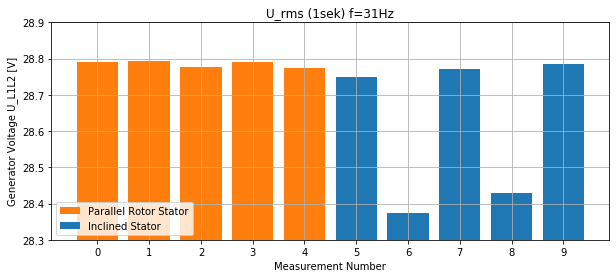

In [14]:
fig, ax = plt.subplots(figsize = (10,4))
#width=0.2
label2='Inclined Stator'
label1='Parallel Rotor Stator'
x=np.arange(10)
data2=scope_dat.loc[scope_dat['Symbol']=='parallel','U_rms']
ax.bar(np.arange(len(data2)),data2,label=label1,color='C1')
data2=scope_dat.loc[scope_dat['Symbol']=='Rotor_Deviated','U_rms']
bar_g=ax.bar(np.arange(len(data2))+5,data2,label=label2,color='C0')
#ax.set_ylim(28.70,29.81)
ax.set_ylim(28.3,28.9)
ax.set_xticks(x)
ax.legend(loc=3)
ax.set_title('U_rms (1sek) f='+str(fc[0])+"Hz")
ax.set_xlabel('Measurement Number')
ax.set_ylabel('Generator Voltage U_L1L2 [V]')
#plt.savefig("UrmsComparison_1sekFFT_Aut.png",dpi=600)
plt.grid(True)

In [ ]:
scope_dat.loc[:,'U_rms']

## (2) Calculate U_RMS 0.2 sek 
* Calculate U_RMS of each measurement within a time interval of 0.2 sek with the average frequency of 31 Hz
* The 0.2 sek interval is positioned in the middle of the previous 1 sek intervall
* 1 revolution takes 0.19 sek at f_el=31Hz

In [ ]:
#Zeit für U-Signal 1 Umlauf, mit allen Polpaaren bie f=31Hz
1/31*6

In [ ]:
ti_col='ti_f'+str(fc[0])+'_nearest_1sek'
#print(ti_col)
for index, row in scope_dat.iterrows():
    scope=pd.read_csv(row['ScopeFile'],sep=",",skiprows=[0],names=['time','sig1'],header=0)
    filter=(scope['time']>(row[ti_col]+0.4))&(scope['time']<(row[ti_col]+0.6))  #vorher 1sek , bei 30 ms werden nicht alle Polpaare berückichtigt
    u=scope.loc[filter,'sig1']
    rms = np.sqrt(np.mean(u**2))
    #print(rms)
    scope_dat.loc[index,'U_rms']=rms

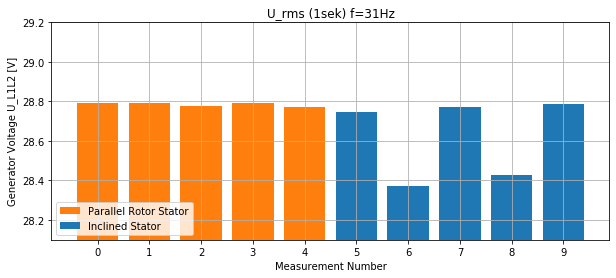

In [15]:
fig, ax = plt.subplots(figsize = (10,4))
#width=0.2
label2='Inclined Stator'
label1='Parallel Rotor Stator'
x=np.arange(10)
data2=scope_dat.loc[scope_dat['Symbol']=='parallel','U_rms']
ax.bar(np.arange(len(data2)),data2,label=label1,color='C1')
data2=scope_dat.loc[scope_dat['Symbol']=='Rotor_Deviated','U_rms']
bar_g=ax.bar(np.arange(len(data2))+5,data2,label=label2,color='C0')
#ax.set_ylim(28.70,29.81)
ax.set_ylim(28.1,29.2)
ax.set_xticks(x)
ax.legend(loc=3)
ax.set_title('U_rms (1sek) f='+str(fc[0])+"Hz")
ax.set_xlabel('Measurement Number')
ax.set_ylabel('Generator Voltage U_L1L2 [V]')
#plt.savefig("UrmsComparison_1sekFFT_Aut.png",dpi=600)
plt.grid(True)

In [16]:
scope_dat.loc[:,'U_rms']

0    28.791874
1    28.792062
2    28.775779
3    28.789610
4    28.772779
5    28.748235
6    28.373345
7    28.770086
8    28.427968
9    28.786233
Name: U_rms, dtype: float64